In [1]:
from google.colab import drive
drive.mount('/content/drive')

!ls "drive/My Drive/Datasets/covid-19/dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
covid  normal


In [0]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data.sampler import SubsetRandomSampler 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

cuda = torch.cuda.is_available()
torch.set_printoptions(sci_mode=False)

In [0]:
data_dir = 'drive/My Drive/Datasets/covid-19/dataset'

transformers = { 'train_transforms': transforms.Compose([
                                                          transforms.Resize((224, 224)),
                                                          transforms.RandomRotation(20),
                                                          transforms.RandomHorizontalFlip(),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])]),
                'test_transforms': transforms.Compose([
                                                          transforms.Resize((224, 224)),
                                                          transforms.CenterCrop(224),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])]),
}

train_data = datasets.ImageFolder(data_dir, transform=transformers['train_transforms'])
test_data = datasets.ImageFolder(data_dir, transform=transformers['test_transforms'])

trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


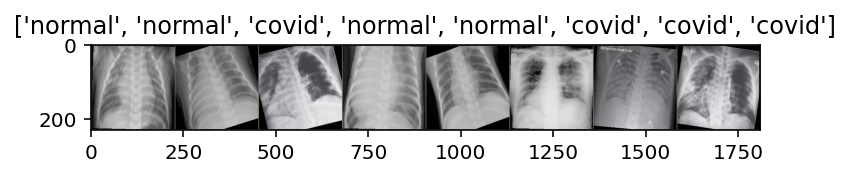

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = inp * std + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

inputs, labels = iter(trainloader).next()
out = torchvision.utils.make_grid(inputs)
class_names = train_data.classes
imshow(out, title = [class_names[x] for x in labels])

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = models.resnet152(pretrained=True)

        for params in self.model.parameters():
            params.require_grad = False
            
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 2),
            nn.LogSoftmax(dim=1))

    def forward(self, x):
        return self.model(x)

model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

if torch.cuda.is_available():
    model.cuda()

In [6]:
epochs = 20
train_losses, test_losses = [], []
acc = []

for e in range(epochs):
    
    training_loss = 0
    testing_loss = 0
    accuracy = 0

    model.train()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()

        output = model(inputs)
        loss = criterion(output, labels)
        training_loss += loss
        loss.backward()

        optimizer.step()
    
    model.eval()
    for inputs, labels in testloader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        with torch.no_grad():
            output = model(inputs)
            testing_loss += criterion(output, labels)
            ps = torch.exp(output)

            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

    acc.append(accuracy/len(testloader))
    train_losses.append(training_loss/len(trainloader))
    test_losses.append(testing_loss/len(testloader))

    print('epoch :', e+1, ' | accuracy :',float(accuracy/len(testloader))*100)

epoch : 1  | accuracy : 58.92857313156128
epoch : 2  | accuracy : 67.85714030265808
epoch : 3  | accuracy : 85.71428656578064
epoch : 4  | accuracy : 91.07142686843872
epoch : 5  | accuracy : 85.71428656578064
epoch : 6  | accuracy : 96.42857313156128
epoch : 7  | accuracy : 91.07142686843872
epoch : 8  | accuracy : 94.64285969734192
epoch : 9  | accuracy : 96.42857313156128
epoch : 10  | accuracy : 91.07142686843872
epoch : 11  | accuracy : 96.42857313156128
epoch : 12  | accuracy : 96.42857313156128
epoch : 13  | accuracy : 96.42857313156128
epoch : 14  | accuracy : 96.42857313156128
epoch : 15  | accuracy : 98.21428656578064
epoch : 16  | accuracy : 98.21428656578064
epoch : 17  | accuracy : 98.21428656578064
epoch : 18  | accuracy : 98.21428656578064
epoch : 19  | accuracy : 100.0
epoch : 20  | accuracy : 100.0


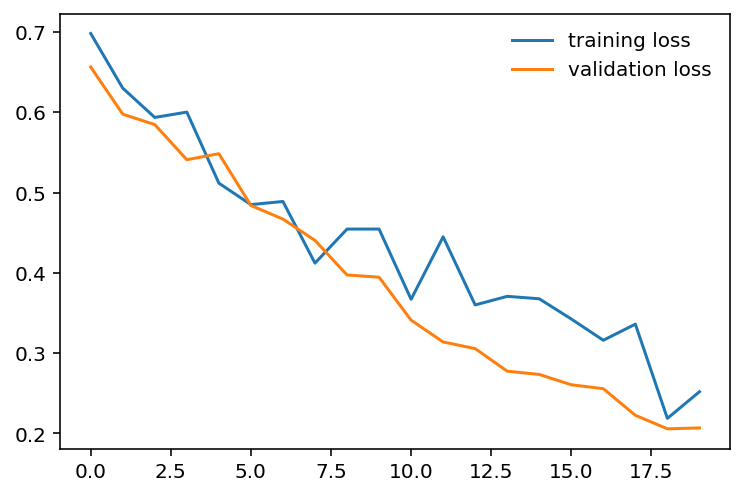

In [7]:
plt.plot(train_losses, label="training loss")
plt.plot(test_losses, label="validation loss")
plt.legend(frameon=False)

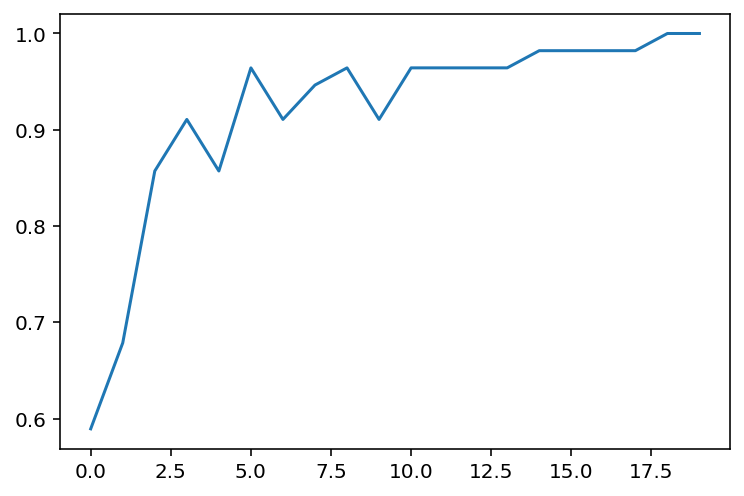

In [8]:
plt.plot(acc, label="accuracy")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction :normal | label :normal


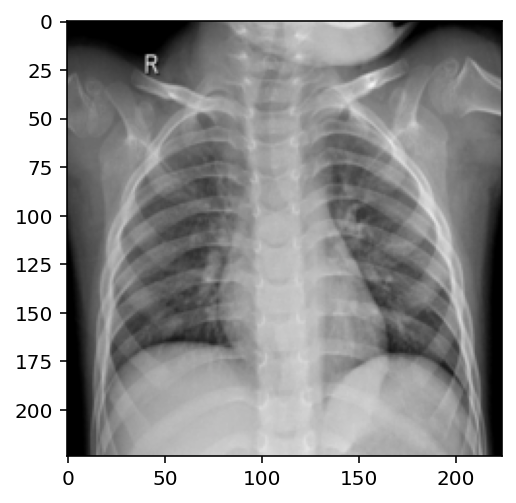

In [30]:
images, labels = iter(testloader).next()
images = images.to('cuda')
predictions = model(images)
predictions = torch.exp(predictions)

images = images.to('cpu')
image = images[0]

labels_ = [class_names[x] for x in labels]
p, classes = predictions.topk(1, dim=1)
predictions_ = [class_names[x] for x in classes]

print('prediction :' + predictions_[0] + ' | label :' + labels_[0])
imshow(image)